In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sklearn

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist

In [3]:

#os.environ["CUDA_VISIBLE_DEVICES"]="0" 

#speed values_2013

data_2013=pd.read_csv("../2013_sw_speed.csv")  ####change location
 

#speedvalues
data_y_2013=data_2013[72:4380]
duration_2013=data_y_2013.iloc[:,4].values
data_speed_2013=data_y_2013.iloc[:,3].values 

# print(data_y_2013.shape)

#speed values_2014

data_2014=pd.read_csv("../2014_sw_speed.csv")  ####change location
 

#speedvalues
data_y_2014=data_2014[49:4380]
duration_2014=data_y_2014.iloc[:,4].values
data_speed_2014=data_y_2014.iloc[:,3].values 

#speed values_2015

data_2015=pd.read_csv("../sw_speed_2015.csv")  ####change location
 

#speedvalues
data_y_2015=data_2015[49:4380]
duration_2015=data_y_2015.iloc[:,4].values
data_speed_2015=data_y_2015.iloc[:,3].values 



#speed values 2017 
data=pd.read_csv("../solar_wind_latest_2017.csv")  ####change location
 

#speedvalues
data_y_2017=data[49:4380]
duration=data_y_2017.iloc[:,4].values
data_speed=data_y_2017.iloc[:,3].values 

#speed_values_2018
data_2018=pd.read_csv("../sw_speed_2018.csv")  ####change location
 

#speedvalues
data_y_2018=data_2018[49:4380]
data_2018_ac=data_2018.iloc[:,3].values
duration_2018=data_y_2018.iloc[:,4].values
data_speed_2018=data_y_2018.iloc[:,3].values 



#merging all data

train_y1=data_y_2013.append(data_y_2014)
train_y2=train_y1.append(data_y_2015)
train_y3=train_y2.append(data_y_2017)
#train_y1=train_y_inter.append(data_y_2015)

trainy_speed=train_y3.iloc[:,3].values #speed of wind 2013-17 target value train_y


print(trainy_speed)
print(trainy_speed.shape)
print(data_speed_2018)  # target test_y assume as train_x_images
print(data_speed_2018.shape)


[358. 354. 351. ... 375. 378. 381.]
(17301,)
[369. 370. 361. ... 477. 470. 462.]
(4331,)


In [4]:
import numpy as np
#Loading training data train_images_2021_logn.npy
# train_x=np.load('/home/hemapriya/ML_SDO/train_images_2021_logn.npy')
#train_x=np.load('../img_full.npy')
train_x=np.load('../train_images_2021_logn.npy')

len(train_x)

17301

In [5]:
data_x = train_x.reshape(train_x.shape[0], 512,512) # training data x
data_x
print(data_x.shape)

data_x_resized=[]
for i in range(len(data_x)):
    data_x_resized.append(cv2.resize(data_x[i], (128, 128)))
print(np.array(data_x_resized).shape)

(17301, 512, 512)
(17301, 128, 128)


In [6]:
data_x_resized=np.array(data_x_resized).reshape(17301,1,128, 128)

print(data_x_resized.shape)


(17301, 1, 128, 128)


(512, 512)


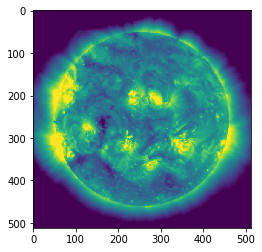

In [7]:
print(data_x[0].shape)
p = data_x[0].reshape(512,512)

plt.imshow(p)

In [8]:
#LOading testing data
test_x=np.load('../img_2018.npy') #shape (88,256,256,1)
test_x=test_x.reshape(4331,512,512)

In [9]:
test_x.shape

(4331, 512, 512)

In [10]:
testx_resized=[]
for i in range(len(test_x)):
    testx_resized.append(cv2.resize(test_x[i], (128, 128)))
#print(np.array(testx_resized).shape)
testx_resized=np.array(testx_resized).reshape(4331,1,128,128)
print(testx_resized.shape)
#test_x1 = test_2018.reshape(test_2018.shape[0], 512,512,1)
#test_x=test_x1[0:4331]
#print((test_x).shape)


#test_x = test_2018[0].reshape(256,256)
#print(test_x)
#plt.imshow(test_x)

(4331, 1, 128, 128)


In [11]:
#import tensorflow as tf
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.compat.v1.Session(config=config)


Graph neural network


In [12]:
class BorisGraphNet(nn.Module):
    def __init__(self, img_size=128, pred_edge=False):   #img_size =28
        super(BorisGraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 1, bias=False) # N,10,bias = False
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.ReLU())  #nn.tanh()
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)

    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)  
        sigma = 0.05 * np.pi
        
        # Below, I forgot to square dist to make it a Gaussian (not sure how important it can be for final results)
        A = np.exp(- dist**2 / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')
            
        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat 

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

In [13]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.shape,target.shape,batch_idx)


        optimizer.zero_grad()
        output = model(data)
        if len(output) == 64:
            output = output.reshape(64)
        else:       
            output = output.reshape(21)
        print(output.shape,batch_idx)
        #loss = F.cross_entropy(output, target)
        loss = F.mse_loss(output,target)
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            

In [14]:
data.shape

(4380, 5)

In [15]:
#     dataset = SolarDataset()
#     testdata=testset()
#     total_samples = len(dataset)
#     n_iterations = math.ceil(total_samples/5)


#     train_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 64,num_workers = 2)


#     test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size = 64, shuffle=True)
#     for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if len(output) == 64:
                output = output.reshape(64)
            else:       
                output = output.reshape(43)
#             test_loss += F.cross_entropy(output, target, reduction='sum').item()
            test_loss += F.mse_loss(output,target)
            
            #pred = output.argmax(dim=1, keepdim=True)
            pred = output
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [17]:
# myfun()
#train_loader = torch.utils.data.DataLoader((data_x,trainy_speed),batch_size = batch, shuffle=True )
#print(len(data_x),type(data_x))  
#print(len(data_speed_2018),type(data_speed_2018))


# !! For Demo Purpose:-  data_x is training images x and data_speed_2018 is target value x 

In [18]:
class SolarDataset(torch.utils.data.Dataset):
  def __init__(self):
    self.x = torch.from_numpy(data_x_resized).float()
    self.y = torch.from_numpy(trainy_speed).float()
    self.n_samples = len(train_x)

  def __getitem__(self,index):
    return self.x[index] ,self.y[index]
  
  def __len__(self):
    return self.n_samples

print(len(data_x_resized))
print(len(trainy_speed))

17301
17301


In [19]:
class testset(torch.utils.data.Dataset):
  def __init__(self):
    self.x = torch.from_numpy(testx_resized).float()
    self.y = torch.from_numpy(data_speed_2018).float()
    self.n_samples = len(testx_resized)

  def __getitem__(self,index):
    return self.x[index] ,self.y[index]
  
  def __len__(self):
    return self.n_samples

For Demo Purpose how to load data using data loader

In [20]:
import math
# dataset = SolarDataset()
# first_Data  = dataset[0]
# features,labels = first_Data
# # print(features,labels)
# # print(features.shape,labels.shape)

# train_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 64,num_workers = 2)

# dataiter = iter(train_loader)
# data = dataiter.next()

# features,labels = data
# print(len(dataset))

# num_epochs = 5
# total_samples = len(dataset)
# n_iterations = math.ceil(total_samples/num_epochs)

# print(total_samples,n_iterations)

# for epoch in range(num_epochs):
#   for i,(inputs,labels) in enumerate(train_loader):
#     #forward,backward, and update
#     if (i+1)% 5 == 0:
#       print(f'epoch {epoch+1}/{num_epochs},step {i+1}/{n_iterations}, inputs {inputs.shape}')


dataset = SolarDataset()
testdata=testset()
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/5)
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")


train_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 64,num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size = 64, shuffle=True)

for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        print(data.shape,target.shape,batch_idx)
        print(len(data),len(target))


torch.Size([64, 1, 128, 128]) torch.Size([64]) 0
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 1
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 2
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 3
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 4
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 5
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 6
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 7
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 8
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 9
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 10
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 11
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 12
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 13
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 14
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 15
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 16
64 64
torch.Size([64, 1, 128, 128]) torch.Size([64]) 17
64 64
to

In [21]:
# for GNN we get 91% accuracy and 89% with gaussian filter
#for GNN we get 88% accuracy while using relu,
    # (0): Linear(in_features=4, out_features=64, bias=True)
    # (1): ReLU()
    # (2): Linear(in_features=64, out_features=1, bias=True)
    # (3): Tanh()
import math

def myfun():   
    use_cuda = False 
    batch = 64
    test_batch_size = 64
    model = 'graph'
    pred_edge = True 
    lr = 0.001
    seed = 1
    log_interval = 200
    
    epochs = 5

    torch.manual_seed(1)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # train_loader = torch.utils.data.DataLoader(
    #     datasets.MNIST('../data', train=True, download=True,
    #                    transform=transforms.Compose([
    #                        transforms.ToTensor(),
    #                        transforms.Normalize((0.1307,), (0.3081,))
    #                    ])),
    #     batch_size= batch, shuffle=True, **kwargs)

    # test_loader = torch.utils.data.DataLoader(
    #     datasets.MNIST('../data', train=False, transform=transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.1307,), (0.3081,))
    #     ])),
    #     batch_size= test_batch_size, shuffle=False,**kwargs)

     
    dataset = SolarDataset()
    testdata=testset()
    total_samples = len(dataset)
    n_iterations = math.ceil(total_samples/epochs)


    train_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch,num_workers = 2)

    test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size = test_batch_size, shuffle=True)

    if model == 'graph':
        model = BorisGraphNet(pred_edge=pred_edge)
    else:
        raise NotImplementedError(model)
        
    model.to(device)


    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-1 if model == 'conv' else 1e-4)
    print('number of trainable parameters: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))
    
    
    
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

In [22]:
data.shape

torch.Size([43, 1, 128, 128])

In [ ]:
myfun()

number of trainable parameters: 16769
torch.Size([64]) 0
Train Epoch: 1 [0/17301 (0%)]	Loss: 31615076352.000000
torch.Size([64]) 1
torch.Size([64]) 2
torch.Size([64]) 3
torch.Size([64]) 4
torch.Size([64]) 5
torch.Size([64]) 6
torch.Size([64]) 7
torch.Size([64]) 8
torch.Size([64]) 9
torch.Size([64]) 10
torch.Size([64]) 11
torch.Size([64]) 12
torch.Size([64]) 13
torch.Size([64]) 14
torch.Size([64]) 15
torch.Size([64]) 16
torch.Size([64]) 17
torch.Size([64]) 18
torch.Size([64]) 19
torch.Size([64]) 20
torch.Size([64]) 21
torch.Size([64]) 22
torch.Size([64]) 23
torch.Size([64]) 24
torch.Size([64]) 25
torch.Size([64]) 26
torch.Size([64]) 27
torch.Size([64]) 28
torch.Size([64]) 29
torch.Size([64]) 30
torch.Size([64]) 31
torch.Size([64]) 32
torch.Size([64]) 33
torch.Size([64]) 34
torch.Size([64]) 35
torch.Size([64]) 36
torch.Size([64]) 37
torch.Size([64]) 38
torch.Size([64]) 39
torch.Size([64]) 40
torch.Size([64]) 41
torch.Size([64]) 42
torch.Size([64]) 43
torch.Size([64]) 44
torch.Size([64]) 

In [ ]:
data.dtype

In [ ]:
#myfun()